In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import random
random.seed(5)
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal,stats
import os
import h5py
from glob import glob

In [2]:
from utils import ReadDatasets

In [3]:
def normalized_stft(
    fid, fs, larmorfreq, window_size, hop_size, window="hann", nfft=None
):
    noverlap = window_size - hop_size

    if not signal.check_NOLA(window, window_size, noverlap):
        raise ValueError(
            "signal windowing fails Non-zero Overlap Add (NOLA) criterion; "
            "STFT not invertible"
        )

    f, t, stft_coefficients = signal.stft(
        fid,
        fs=fs,
        nperseg=window_size,
        window=window,
        noverlap=noverlap,
        nfft=nfft,
        return_onesided=False,
    )

    f = np.concatenate([np.split(f, 2)[1], np.split(f, 2)[0]])
    ppm = 4.65 + f / larmorfreq

    stft_coefficients_ordered = np.concatenate(
        [np.split(stft_coefficients, 2)[1], np.split(stft_coefficients, 2)[0]]
    )
    
    #stft_coefficients_ordered = np.flip(stft_coefficients_ordered, axis=0)
    #stft_coefficients_onesided = stft_coefficients_ordered[(ppm >= 0), :]

    stft_coefficients_onesided = stft_coefficients_ordered[(ppm >= 0), :]
    stft_coefficients_onesided = np.flip(stft_coefficients_onesided, axis=0)

    stft_coefficients_onesided_norm = stft_coefficients_onesided / (
        np.max(np.abs(stft_coefficients_onesided))
    )

    return stft_coefficients_onesided_norm, f, ppm, t

In [4]:
def get_normalized_spgram(
    fid, fs, larmorfreq, linear_shift, window_size, hop_size, window, nfft=None,SFT=None
):

    noverlap = window_size - hop_size
    if not signal.check_NOLA(window, window_size, noverlap):
        raise ValueError(
            "signal windowing fails Non-zero Overlap Add (NOLA) criterion; "
            "STFT not invertible"
        )
    if nfft == None:
        nfft = window_size

    if SFT == None:
        SFT = signal.ShortTimeFFT(
            win=window,
            hop=hop_size,
            fs=fs,
            mfft=nfft,
            scale_to="magnitude",
            fft_mode="centered",
        )
    t_lo, t_hi, f_lo, f_hi = SFT.extent(fid.shape[0])

    stft_coefficients = SFT.stft(fid)
    f = np.linspace(f_lo, f_hi, nfft)
    t = np.linspace(t_lo, t_hi, stft_coefficients.shape[1])
    ppm = linear_shift + f / larmorfreq

    zero_idx = np.abs(t - 0.0).argmin()
    one_idx = np.abs(t - 1.0).argmin()
    t = t[zero_idx:one_idx]
    stft_coefficients = stft_coefficients[:, zero_idx:one_idx]

    # opt 1: Gab
    # stft_coefficients_ordered = np.flip(stft_coefficients, axis=0)
    # stft_coefficients_onesided = stft_coefficients_ordered[(ppm >= 0), :]
    # opt 2:
    stft_coefficients_onesided = stft_coefficients[(ppm >= 0), :]
    stft_coefficients_onesided = np.flip(stft_coefficients_onesided, axis=0)
    # opt 3:
    # stft_coefficients_onesided = np.flip(stft_coefficients, axis=0)
    stft_coefficients_onesided_norm = stft_coefficients_onesided / (
        np.max(np.abs(stft_coefficients_onesided))
    )

    return stft_coefficients_onesided_norm, f, ppm, t

In [5]:
files_valid = sorted(glob(os.path.join('../Dados_MRS-20240506T181721Z-001/Dados_MRS', "valid", "*.h5")))

In [6]:
transients = []
target_spectrum = []
ppm = []
fs = []
tacq = []
larmorfreq = []
for file in files_valid:
    transient_, target_, ppm_, fs_, tacq_, larmorfreq_ = ReadDatasets.read_h5_complete(file)
    transients.append(transient_)
    target_spectrum.append(target_)
    ppm.append(ppm_)
    fs.append(fs_)
    tacq.append(tacq_)
    larmorfreq.append(larmorfreq_)


In [18]:
stft_g, f_g, ppm_g, t_g = normalized_stft(fid=np.mean(transients[0][:,1,:]-transients[0][:,0,:],axis=-1), fs=fs[0], larmorfreq=larmorfreq[0], window_size=256, hop_size=64, window="hann")
stft_l, f_l, ppm_l, t_l = get_normalized_spgram(fid=np.mean(transients[0][:,1,:]-transients[0][:,0,:],axis=-1), fs=fs[0], larmorfreq=larmorfreq[0], linear_shift=4.65, window_size=256, hop_size=64, window=signal.windows.hann(256,sym=True))

In [19]:
print(stft_g.shape,stft_l.shape)
print(f_g.shape,f_l.shape)
print(ppm_g.shape,ppm_l.shape)
print(t_g.shape,t_l.shape)

(158, 65) (158, 65)
(256,) (256,)
(256,) (256,)
(65,) (65,)


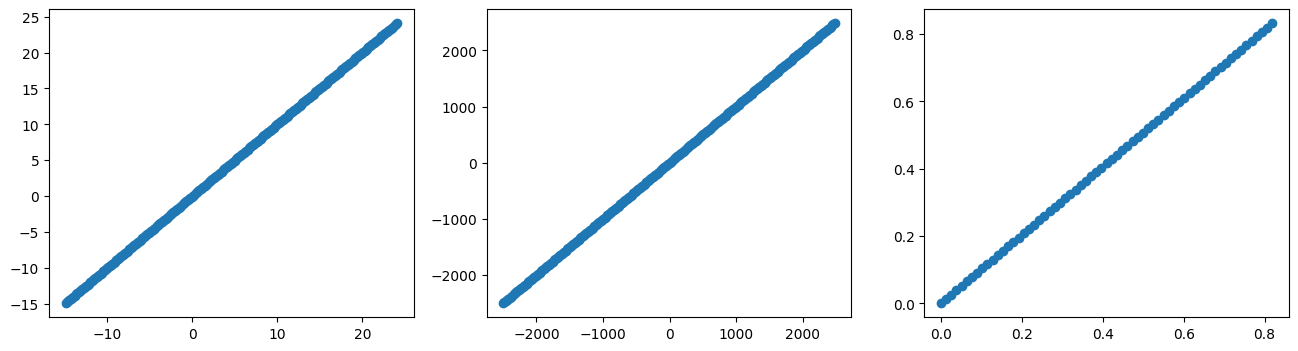

In [21]:
fig, ax = plt.subplots(1,3, figsize=(16,4))
ax[0].scatter(ppm_g,ppm_l)
ax[1].scatter(f_g,f_l)
ax[2].scatter(t_g,t_l)

In [16]:
ppm_g_aux = ppm_g[ppm_g >= 0]
ppm_l_aux = ppm_l[ppm_l >= 0]

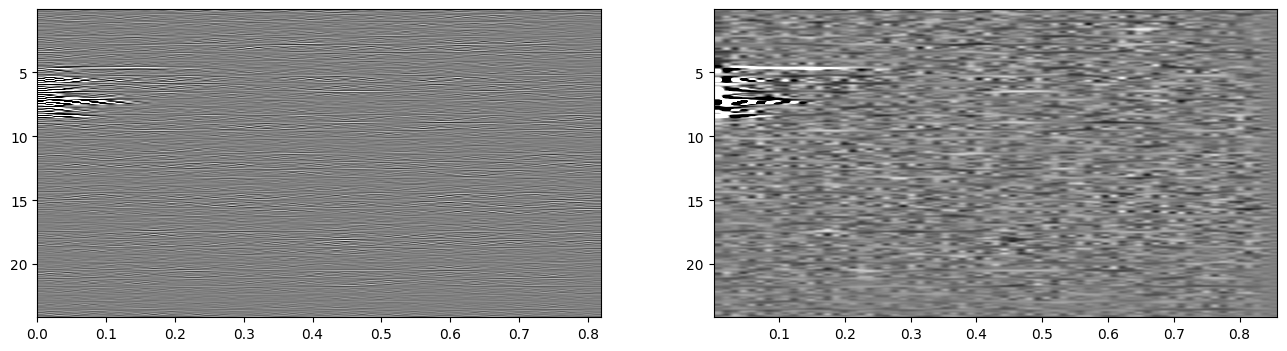

In [17]:
fig, ax = plt.subplots(1,2, figsize=(16,4))
ax[0].imshow(np.real(stft_g),origin='lower',aspect='auto', cmap='gray',vmin=-0.02,vmax=0.02,
             extent = (t_g[0],t_g[-1],ppm_g_aux[-1],ppm_g_aux[0]))
ax[1].imshow(np.real(stft_l),origin='lower',aspect='auto', cmap='gray',vmin=-0.02,vmax=0.02,
             extent = (t_l[0],t_l[-1],ppm_l_aux[-1],ppm_l_aux[0]))

Não importa para o modelo, mas é muito esquisito que a região onde está o sinal corresponde de 5 a 10 ppm... E que os picos estejam tão unidos dessa forma.

In [13]:
spectrum = np.fft.fftshift(np.fft.fft(np.mean(transients[:,1,:]-transients[:,0,:],axis=1),n=4096))
freq_spectrum = np.fft.fftshift(np.fft.fftfreq(4096, d = 1/fs))
ppm_spectrum = 4.65 + freq_spectrum/larmorfreq

(-2.0, 12.0)

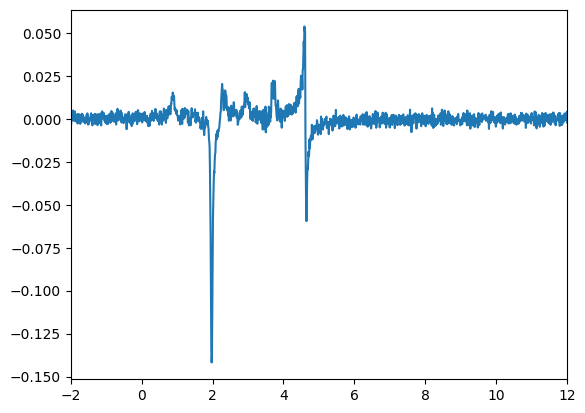

In [16]:
plt.plot(np.flip(ppm_spectrum),np.real(spectrum))
plt.xlim(-2,12)

In [17]:
ppm_spectrum

array([-14.92492977, -14.9153717 , -14.90581363, ...,  24.19625556,
        24.20581363,  24.2153717 ])

In [19]:
ppm_spgm

array([-14.92492977, -14.77200063, -14.6190715 , -14.46614236,
       -14.31321322, -14.16028408, -14.00735494, -13.8544258 ,
       -13.70149666, -13.54856752, -13.39563839, -13.24270925,
       -13.08978011, -12.93685097, -12.78392183, -12.63099269,
       -12.47806355, -12.32513441, -12.17220527, -12.01927614,
       -11.866347  , -11.71341786, -11.56048872, -11.40755958,
       -11.25463044, -11.1017013 , -10.94877216, -10.79584302,
       -10.64291389, -10.48998475, -10.33705561, -10.18412647,
       -10.03119733,  -9.87826819,  -9.72533905,  -9.57240991,
        -9.41948077,  -9.26655164,  -9.1136225 ,  -8.96069336,
        -8.80776422,  -8.65483508,  -8.50190594,  -8.3489768 ,
        -8.19604766,  -8.04311853,  -7.89018939,  -7.73726025,
        -7.58433111,  -7.43140197,  -7.27847283,  -7.12554369,
        -6.97261455,  -6.81968541,  -6.66675628,  -6.51382714,
        -6.360898  ,  -6.20796886,  -6.05503972,  -5.90211058,
        -5.74918144,  -5.5962523 ,  -5.44332316,  -5.29

In [8]:
spg.shape

(256, 351)

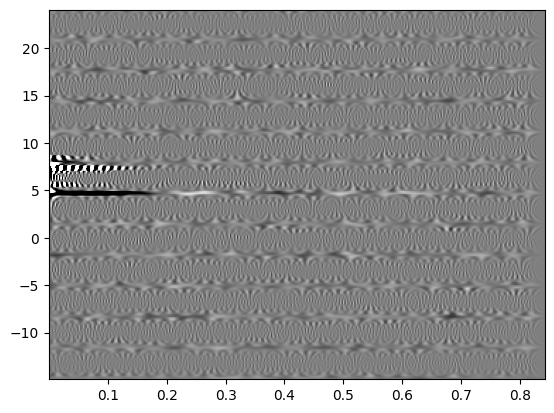

In [30]:
plt.imshow(np.real(spg[:,:]),cmap='gray',vmin=-0.04,vmax=0.04,aspect='auto', origin='lower',
           extent=(t_spgm[0],t_spgm[-1],ppm_spgm[0],ppm_spgm[-1]))

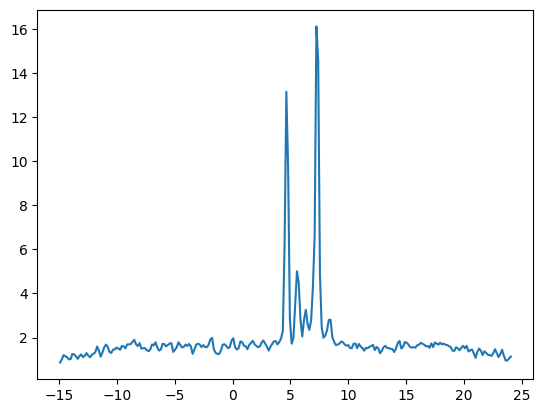

In [32]:
plt.plot(ppm_spgm,np.sum(np.abs(np.real(spg)),axis=1))